# Time series - multivariate prediction, LSTM for continuous prediction

In this example we will load prepared data and try to predict it with a lstm network producing continuous prediction

This example is very similar to the last lstm example except the model is trained to predict one step into the future that can be used for latter predictions.

In [1]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 30
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/training_set_temp_dp_press.p'
training_df = pd.read_pickle(PATH)

Notice that we would randomly sample the training data from the whole weather history.

The `indices` array will contain starting date for each sample

In [0]:
import random

PREDICTION_LEN = 7
HISTORY_LEN = 14
NUM_SAMPLES = 2000
NUM_INPUTS = len(training_df.columns)

You can sample from the training set randomly:

In [0]:
indices = random.sample(range(0,len(training_df) - HISTORY_LEN - 1), NUM_SAMPLES)

... or you can sample sequetially:

In [0]:
indices = list(range(0, len(training_df) - HISTORY_LEN - 1, HISTORY_LEN))
random.shuffle(indices)

In this example the target sequence is shifted one step into the future. The model need to accumulate information in its inner state to correctly predict it.

Both input and output tensors remain in sequence form.

In [0]:
ts_data = training_df.values
ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN] for i in indices])

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense

inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(x)
outputs = Dense(NUM_INPUTS)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 4)]           0         
_________________________________________________________________
gru (GRU)                    (None, 14, 64)            13440     
_________________________________________________________________
gru_1 (GRU)                  (None, 14, 32)            9408      
_________________________________________________________________
dense (Dense)                (None, 14, 4)             132       
Total params: 22,980
Trainable params: 22,980
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(ts_inputs, ts_outputs, validation_split=0.1, epochs=200)

In [0]:
model.save_weights('model_plus1_predition.h5')

## Prediction phase

To test the prediction, we will take a particular date and feed the history into the network.

The network will predict one step into the future and we will take this prediction and feed it back to the network. In this way, we can predict multiple (and variable) steps into the future

Notice that the model is `stateful` i.e. the hidden state does not reset after the prediction.

In [11]:
inputs = Input(batch_shape=(1, 1, NUM_INPUTS))
x = GRU(64, return_sequences=True, stateful=True)(inputs)
x = GRU(32, return_sequences=True, stateful=True)(x)
outputs = Dense(NUM_INPUTS)(x)

pred_model = Model(inputs, outputs)
pred_model.summary()
pred_model.load_weights('model_plus1_predition.h5')


def self_predict(prediction_input):

    pred_model.reset_states()
    for i in range(0, HISTORY_LEN):
        prediction = pred_model.predict(prediction_input.values[i].reshape(1, 1, NUM_INPUTS))
        
    self_predicition = [np.copy(prediction)]

    for i in range(0, PREDICTION_LEN - 1):
        prediction = pred_model.predict(self_predicition[i])
        self_predicition.append(np.copy(prediction))
    
    return self_predicition

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1, 1, 4)]               0         
_________________________________________________________________
gru_2 (GRU)                  (1, 1, 64)                13440     
_________________________________________________________________
gru_3 (GRU)                  (1, 1, 32)                9408      
_________________________________________________________________
dense_1 (Dense)              (1, 1, 4)                 132       
Total params: 22,980
Trainable params: 22,980
Non-trainable params: 0
_________________________________________________________________


## Evaluation

First, let's see how a single sample from testing set look like:

In [0]:
import datetime
from datetime import timedelta

In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/testing_set_temp_dp_press.p'
testing_df = pd.read_pickle(PATH)

In [0]:
def show_prediction(prediction_date):
    
    self_predicition = self_predict(testing_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date])

    history = testing_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]
    prediction_df = pd.DataFrame(
        np.vstack(self_predicition).reshape((PREDICTION_LEN, NUM_INPUTS)), 
        index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN)
    )

    plt.figure(figsize = (12, 6))
    history_plt = plt.plot(history.iloc[:,0:3], linestyle='--')
    plt.plot(history.iloc[:,3], 'oc')
    plt.plot(prediction_df.iloc[:,0], color=history_plt[0].get_color())
    plt.plot(prediction_df.iloc[:,1], color=history_plt[1].get_color())
    plt.plot(prediction_df.iloc[:,2], color=history_plt[2].get_color())
    plt.plot(prediction_df.iloc[:,3], 'or')
    plt.show()

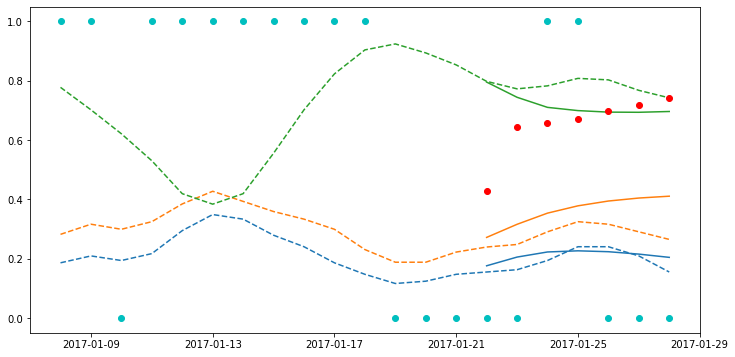

In [16]:
show_prediction(date(2017, 1, 21))


... now, let's do some quantitative measurements against a simple baseline (constant model)

In [0]:
from tqdm import tqdm_notebook as tqdm

def evaluate_one(prediction_date):
    prediction_input = testing_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]

    self_predicition = self_predict(prediction_input)

    prediction = np.vstack(self_predicition).reshape((PREDICTION_LEN, NUM_INPUTS))
    ground_truth = testing_df[prediction_date + timedelta(days=1) : prediction_date + timedelta(days=PREDICTION_LEN)].values
    baseline_prediction = np.tile(testing_df.loc[prediction_date], (PREDICTION_LEN, 1))

    return (
        np.sum((prediction[:,:3] - ground_truth[:,:3]) ** 2), 
        np.sum((baseline_prediction[:,:3] - ground_truth[:,:3]) ** 2)
    )

def evaluate_all():
    baseline_error = 0
    model_error = 0

    for i in tqdm(range(2, 52)):
        prediction_date = date(2016,12,31) + timedelta(days=i * PREDICTION_LEN)
        model_e, baseline_e = evaluate_one(prediction_date)
        model_error += model_e
        baseline_error += baseline_e

    return model_error, baseline_error

In [18]:
evaluate_all()

(6.584022868098161, 9.392287473402634)

## Multiple loss functions

To correctly handle this example, we should be training the network with multiple loss fuctions as prediction of precipitation is a binary classification task.

In [19]:
ts_outputs_1 = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN, 0:3] for i in indices])
ts_outputs_2 = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN, 3] for i in indices])

print(ts_outputs_1.shape)
print(ts_outputs_2.shape)

(417, 14, 3)
(417, 14)


In [20]:
inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(x)
outputs_1 = Dense(3)(x)
outputs_2 = Dense(1, activation="sigmoid")(x)

model = Model(inputs, [outputs_1, outputs_2])
model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[1.0, 0.01])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 14, 4)]      0                                            
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 14, 64)       13440       input_3[0][0]                    
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, 14, 32)       9408        gru_4[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 14, 3)        99          gru_5[0][0]                      
____________________________________________________________________________________________

In [0]:
model.fit(ts_inputs, [ts_outputs_1, ts_outputs_2], validation_split=0.1, epochs=200)

In [0]:
model.save_weights('model_plus1_mult_predition.h5')

In [23]:
inputs = Input(batch_shape=(1, 1, NUM_INPUTS))
x = GRU(64, return_sequences=True, stateful=True)(inputs)
x = GRU(32, return_sequences=True, stateful=True)(x)
outputs_1 = Dense(3)(x)
outputs_2 = Dense(1, activation='sigmoid')(x)

pred_model = Model(inputs, [outputs_1, outputs_2])
pred_model.summary()
pred_model.load_weights('model_plus1_mult_predition.h5')

def self_predict(prediction_input):

    pred_model.reset_states()
    for i in range(0, HISTORY_LEN):
        prediction_1, prediction_2 = pred_model.predict(prediction_input.values[i].reshape(1, 1, NUM_INPUTS))

    self_predicition = [np.concatenate((prediction_1, prediction_2), axis=-1)]

    for i in range(0, PREDICTION_LEN - 1):
        prediction_1, prediction_2 = pred_model.predict(self_predicition[i])

        self_predicition.append(np.concatenate((prediction_1, prediction_2), axis=-1))
    
    return self_predicition

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(1, 1, 4)]          0                                            
__________________________________________________________________________________________________
gru_6 (GRU)                     (1, 1, 64)           13440       input_4[0][0]                    
__________________________________________________________________________________________________
gru_7 (GRU)                     (1, 1, 32)           9408        gru_6[0][0]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (1, 1, 3)            99          gru_7[0][0]                      
____________________________________________________________________________________________

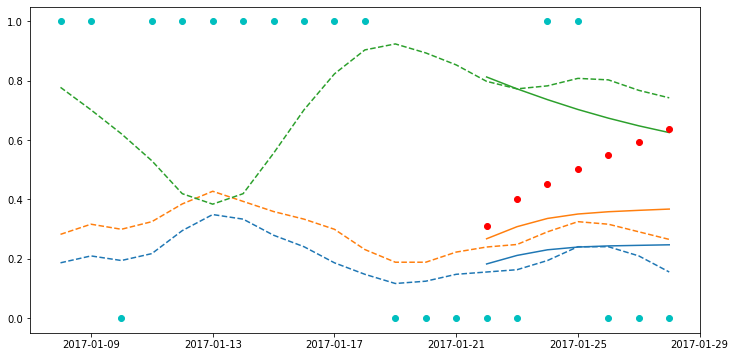

In [24]:
show_prediction(date(2017, 1, 21))

In [25]:
evaluate_all()

(6.4065205998522226, 9.392287473402634)

## Encoder-Decoder example

Finally, let's see if we can make a better model for long-term prediction than the previous self-feeded +1 day. We are going to use the seq2seq model usually seen in machine-translation tasks (see https://keras.io/examples/lstm_seq2seq/)

In [26]:
inputs = Input(shape=ts_inputs.shape[1:])
_, states_h, states_c = LSTM(128, return_state=True)(inputs)
encoder_states = [states_h, states_c]

x = LSTM(128, return_sequences=True)(inputs, initial_state=encoder_states)
outputs_1 = Dense(3)(x)
outputs_2 = Dense(1, activation="sigmoid")(x)

model = Model(inputs, [outputs_1, outputs_2])
model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[1.0, 0.01])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14, 4)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 68096       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 14, 128)      68096       input_5[0][0]                    
                                                                 lstm[0][1]                       
                                                                 lstm[0][2]                       
____________________________________________________________________________________________

In [27]:
indices = list(range(0, len(training_df) - 2 * HISTORY_LEN, HISTORY_LEN))
random.shuffle(indices)

ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs_1 = np.array([ts_data[i + HISTORY_LEN: i + 2 * HISTORY_LEN, 0:3] for i in indices])
ts_outputs_2 = np.array([ts_data[i + HISTORY_LEN: i + 2 * HISTORY_LEN, 3] for i in indices])

print(ts_inputs.shape)
print(ts_outputs_1.shape)
print(ts_outputs_2.shape)

(416, 14, 4)
(416, 14, 3)
(416, 14)


In [0]:
model.fit(ts_inputs, [ts_outputs_1, ts_outputs_2], validation_split=0.1, epochs=200)

In [0]:
def self_predict(prediction_input):
    prediction_1, prediction_2 = model.predict(prediction_input.values.reshape(1, HISTORY_LEN, NUM_INPUTS))
    return np.concatenate((prediction_1, prediction_2), axis=-1)[0,:PREDICTION_LEN,:]    

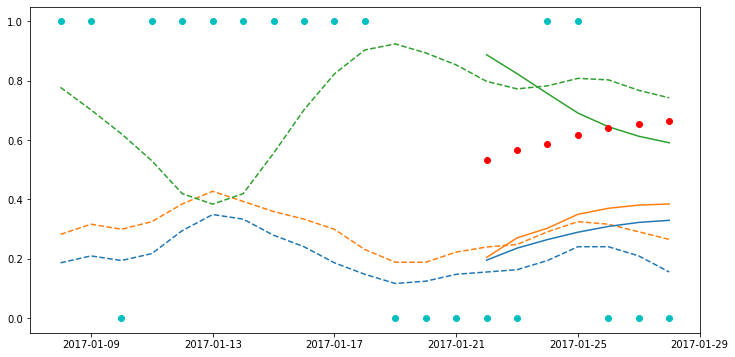

In [30]:
show_prediction(date(2017, 1, 21))

In [31]:
evaluate_all()

(8.424325294685467, 9.392287473402634)